# Extraction of SWR from CA1 recordings

Restarting from LFPwake0 and LFPwakeremoved.

LFPwakeremoved will be used to determined signal variance for threshold adjustement. 

LFPwake0 will be used for time determination. 

## Load LFP and packages

In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
from scipy import stats

import pandas as pd
from pathlib import Path
%matplotlib widget

/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_65719/824995415.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:


folder_base = Path('/Users/ahay/Documents/DATA/NPX/NPX3/reuniens/')

filename = folder_base / f'LFPwake0.npy'
filename3 = folder_base / f'LFPwakeremoved.npy'
filename2 = folder_base / f'RawDataChannelExtractedDS.npy'
EMGbooleaninput = folder_base / f'EMGframeBoolean.pkl'

EMGboolean = pd.read_pickle(EMGbooleaninput)
LFPwakeremoved = np.load(filename3, mmap_mode= 'r')
All = np.load(filename2, mmap_mode= 'r')
All = All.T
CA1 = All[:, 14]-All[:, 15]
CA1wakeremoved = LFPwakeremoved[:, 14]-LFPwakeremoved[:,15]
CA1.shape

#CA1 = CA1[:10000000]
#CA1wakeremoved = CA1wakeremoved[:10000000]
#EMGboolean = EMGboolean[:10000000]

(6849690,)

# Band pass filter
        SWR: 120-200 Hz

In [3]:
# Filtre parameter:
f_lowcut = 130.
f_hicut = 210.
fs = 1000
nyq = 0.5 * fs
N = 6                 # Filtre order
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

# Filtering:
b, a = signal.butter(N, Wn, 'band')
filt_CA1 = signal.filtfilt(b, a, CA1)
filt_CA1wakeremoved = signal.filtfilt(b, a, CA1wakeremoved)

# Plot
#times = np.arange(0, CA1.size/fs, 1./fs)
#timesmin = np.arange(0, CA1.size/fs/60, 1./fs/60)
#fig, ax = plt.subplots()
#ax.plot(timesmin, filt_CA1)

## Continuous Wavelet Transform and projection calculation

First on signal with no wake time to determine sd of signal

In [4]:
# Parameter and computation of CWT
w = 10.
freq = np.linspace(140, 200, 60)
widths = w*fs / (2*freq*np.pi)
CA1NWcwt = signal.cwt(CA1wakeremoved, signal.morlet2, widths, w=w)

# Projection calculation
zCA1WNWcwt = stats.zscore(CA1NWcwt, axis=1)
absCA1NWcwt = np.absolute(zCA1WNWcwt)
proj_CA1NWcwt = np.sum(absCA1NWcwt, axis = 0)/60
sdproj_CA1cwt = np.std(proj_CA1NWcwt)
msdproj_CA1cwt = np.mean(proj_CA1NWcwt)
sd3proj_CA1cwt = msdproj_CA1cwt + sdproj_CA1cwt*4
sd05proj_CA1cwt = msdproj_CA1cwt + sdproj_CA1cwt*2.5
sd1proj_CA1cwt = msdproj_CA1cwt + sdproj_CA1cwt


/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_53944/3554687319.py:5: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  CA1NWcwt = signal.cwt(CA1wakeremoved, signal.morlet2, widths, w=w)


In [5]:
CA1NWcwt = []
zCA1WNWcwt = []
absCA1NWcwt = []

In [17]:
sd3proj_CA1cwt = msdproj_CA1cwt + sdproj_CA1cwt*4


Second on the signal for which wake times have been zeroed

In [18]:
# Conservative boolean filtering of CA1 filtered signal
#BooleanCons = EMGboolean['BooleanConservative']
#fCA1wake0C = filt_CA1.copy()
#fCA1wake0C[BooleanCons] = 0
#CA1wake0C = CA1.copy()
#CA1wake0C[BooleanCons] = 0
# Liberal boolean filtering of CA1 filtered signal
BooleanLib = EMGboolean['BooleanLiberal']
fCA1wake0L = filt_CA1.copy()
fCA1wake0L[BooleanLib] = 0
CA1wake0L = CA1.copy()
CA1wake0L[BooleanLib] = 0

# Computation of CWT
#CA1cwtWake0cons = signal.cwt(fCA1wake0C, signal.morlet2, widths, w=w)
CA1cwtWake0lib = signal.cwt(fCA1wake0L, signal.morlet2, widths, w=w)

# Projection calculation
#absCA1W0Ccwt = np.absolute(CA1cwtWake0cons)
#proj_CA1W0Ccwt = np.sum(absCA1W0Ccwt, axis = 0)/80
zCA1W0Lcwt = stats.zscore(CA1cwtWake0lib, axis=1)
absCA1W0Lcwt = np.absolute(zCA1W0Lcwt)
proj_CA1W0Lcwt = np.sum(absCA1W0Lcwt, axis = 0)/60

/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_53944/380422852.py:16: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  CA1cwtWake0lib = signal.cwt(fCA1wake0L, signal.morlet2, widths, w=w)


In [19]:
zCA1W0Lcwt = []

np.mean(sd3proj_CA1cwt)

3.075194296760705

## Extracting SWRs and determining main properties 

First extraction of SWR peaks, initiation, end and width

In [20]:
from scipy.signal import find_peaks
from scipy.signal import chirp, find_peaks, peak_widths

# 3 sd threshold
peaks, properties = find_peaks(proj_CA1W0Lcwt, prominence=1, width=20, height=sd3proj_CA1cwt)
properties["prominences"], properties["widths"]

# SWR boundaries taken at 70% from peak of intensity. This means that the SWRs with small amplitude will be longer than the big ones.
results_width = peak_widths(proj_CA1W0Lcwt, peaks, rel_height=0.7)

# Organise results in numpy array
peaks2 = peaks.reshape(len(peaks),1)
npresults_width = np.array(results_width).reshape(4,-1)
SWR_prop = np.append(peaks2, results_width).reshape(5,len(peaks2)).round()

Second extraction of main frequency and power 

In [21]:
projMaxP_cwtmg = np.max(CA1cwtWake0lib, axis = 0)
projMaxF_cwtmg = np.argmax(CA1cwtWake0lib, axis = 0) + 140
projMaxP_cwtmg.shape
CA1cwtWake0lib = []
nb_SWR = np.arange(0,len(peaks),1)
data = np.zeros((len(peaks),4))

for tt in nb_SWR:
    SWR_start = int(SWR_prop[3,tt])
    SWR_stop = int(SWR_prop[4,tt])
    SWR_MaxP = projMaxP_cwtmg[SWR_start:SWR_stop]
    SWR_MaxF = projMaxF_cwtmg[SWR_start:SWR_stop]
    data[tt, 0] = max(SWR_MaxF).round()
    data[tt, 1] = max(SWR_MaxP).round()
    data[tt, 2] = round(sum(SWR_MaxF)/len(SWR_MaxF))
    data[tt, 3] = round(sum(SWR_MaxP)/len(SWR_MaxP))

param_SWR = pd.DataFrame(data, columns = ['Max freq', 'Max int', 'Avg freq', 'Avg int'])
tSWR_prop = SWR_prop.transpose()
pd_prop_SWR = pd.DataFrame(tSWR_prop, columns = ['peak time', 'Duration', 'peak amp', 'start time', 'end time'])
All_SWR = pd.concat([pd_prop_SWR, param_SWR], axis=1)

/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_53944/3724582012.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  data[tt, 1] = max(SWR_MaxP).round()
/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_53944/3724582012.py:16: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  data[tt, 3] = round(sum(SWR_MaxP)/len(SWR_MaxP))
/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_53944/3724582012.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  data[tt, 3] = round(sum(SWR_MaxP)/len(SWR_MaxP))


### Store the results in All_SWR_prop pd dataframe and save as pkl/csv for post processing.

End of Notebook. 

In [22]:
filename2 = folder_base / f'ca1SWRproperties.pkl'
filename3 = folder_base / f'ca1SWRproperties.csv'
All_SWR.to_pickle(filename2)
All_SWR.to_csv(filename3, sep = ',')


combined = np.stack([fCA1wake0L, proj_CA1W0Lcwt], axis = 1)
filenameC = folder_base / f'SignalCA1.npy'
np.save(filenameC, combined)

# if done and no intention to display for assessment
#%reset
#plt.close('all')

In [3]:
filename3 = folder_base / f'ca1SWRproperties.csv'
SWR_prop = pd.read_csv(filename3)
SWR_prop = SWR_prop.dropna(axis=0, how='all')

filenameC = folder_base / f'SignalCA1.npy'
CA1wo = np.load(filenameC, mmap_mode= 'r')
fCA1wake0L = CA1wo[:,0]
proj_CA1W0Lcwt = CA1wo[:,1]


In [4]:
SWR_peak = SWR_prop['peak time'].astype(int)#peaks
SWR_start = SWR_prop['start time'].astype(int)#SWR_prop[3,:].astype(int)
SWR_end = SWR_prop['end time'].astype(int)#SWR_prop[4,:].astype(int)

# #create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: SWR_peak, 1: SWR_start, 2: SWR_end}
# #and asign them to some channels each
scatter_channels = {0: [0, 2], 1: [0, 1], 2: [0, 1]}
len(SWR_peak)

2853

In [14]:
filenameTTL = folder_base / f'timestamps.npy'
TTL = np.load(filenameTTL, mmap_mode= 'r')

TTLpropfake = []
TTLprop = []

for ic in TTL:
    ic2 = round(ic)
    if ic2 not in TTLpropfake:
        TTLpropfake.append(ic2)
        TTLprop.append(ic)

TTLprop2 = [i * 1000 for i in TTLprop]
TTLprop2 = [round(i) for i in TTLprop2]
TTLprop = pd.DataFrame(TTLprop2, columns = ['Start'])
filename3 = folder_base / f'TTLproperties.csv'
TTLprop.to_csv(filename3, sep = ',')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ahay/Documents/DATA/NPX/NPX3/reuniens/timestamps.npy'

In [15]:

filenameTTL = folder_base / f'TTLproperties.csv'
Timestamps = pd.read_csv(filenameTTL)
Timestamps['Start']
TTL = Timestamps['Start']
TTL

Series([], Name: Start, dtype: object)

### Display

ephys viewer to check SWR detection

In [5]:


from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer
#TTL = All[0:10000000, 11]#
combined = np.stack([-CA1, -fCA1wake0L, proj_CA1W0Lcwt, proj_CA1W0Lcwt, -CA1], axis = 1)

app = mkQApp()

sample_rate = 1000.
t_start = 0.

#SWR_peak = TTL


#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: SWR_peak, 1: SWR_start, 2: SWR_end}
#and asign them to some channels each
scatter_channels = {0: [0, 2], 1: [0, 1], 2: [0, 1]}
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#ffffff'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#ff5500'
view1.by_channel_params['ch3', 'color'] = '#ffffff'
view1.by_channel_params['ch4', 'color'] = '#ffffff'

view1.by_channel_params['ch0', 'gain'] = 0.001
view1.by_channel_params['ch1', 'gain'] = 0.003
view1.by_channel_params['ch2', 'gain'] = 0.1#003
view1.by_channel_params['ch3', 'gain'] = 0.1#003
view1.by_channel_params['ch4', 'gain'] = 0.001

view1.by_channel_params['ch0', 'offset'] = 1
view1.by_channel_params['ch1', 'offset'] = -1
view1.by_channel_params['ch2', 'offset'] = -1
view1.by_channel_params['ch3', 'offset'] = -1
view1.by_channel_params['ch4', 'offset'] = 1
#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec_()

debug True
QT_MODE PyQt5
refresh duration for  7.677078247070312e-05 s
refresh duration for  0.0004470348358154297 s
refresh duration for  0.00043487548828125 s
refresh duration for  0.0003848075866699219 s
refresh duration for  0.0004830360412597656 s
refresh duration for  0.00033402442932128906 s
refresh duration for  0.0003058910369873047 s
refresh duration for  0.0002009868621826172 s
refresh duration for  0.00018596649169921875 s
refresh duration for  0.0002760887145996094 s
refresh duration for  0.00017976760864257812 s
refresh duration for  0.0001761913299560547 s
refresh duration for  0.0004017353057861328 s
refresh duration for  0.00019788742065429688 s
refresh duration for  0.0001709461212158203 s
refresh duration for  0.00025916099548339844 s
refresh duration for  0.0002257823944091797 s
refresh duration for  0.0003859996795654297 s
refresh duration for  0.0003669261932373047 s
refresh duration for  0.00034809112548828125 s
refresh duration for  0.00041604042053222656 s
refr

0

Quick plot of average and max intensity (can be done with freq as well) paired.

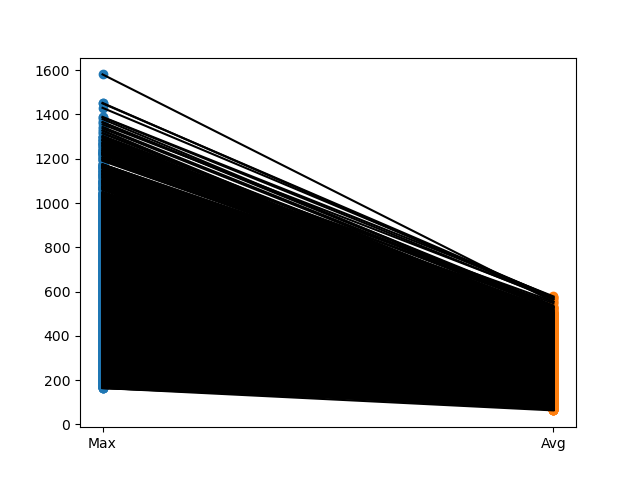

In [17]:

# input data:
MaxSWR = param_SWR['Max int']
AvgSWR = param_SWR['Avg int']

# plotting the points
plt.scatter(np.zeros(len(MaxSWR)), MaxSWR)
plt.scatter(np.ones(len(AvgSWR)), AvgSWR)

# plotting the lines
for i in range(len(MaxSWR)):
    plt.plot( [0,1], [MaxSWR[i], AvgSWR[i]], c='k')

plt.xticks([0,1], ['Max', 'Avg'])
plt.show()

In [18]:
TTL
TTLint = []
i = 0
dum = 0
for tt in TTL:
    TTLint.append(tt - dum)
    dum = tt
    i = i + 1
npTTL = np.array(TTLint)
TTLclean = npTTL[npTTL < 8000]
mTTLclean = sum(TTLclean)/len(TTLclean)
mTTLclean
TTLclean

ZeroDivisionError: division by zero